# Categorization machine learning demo
The goal of this notebook is to use illustrate the basic mathods of setting up a neural network meant to categorize data. This will also demonstrate how to utilize GPUs and some basic plots to measure the success of the network. For this problem, we will use [Cross Entropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) to measure network performance.

In [1]:
import torch
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from tqdm import tqdm
from torchmetrics import ROC

/tmpscratch/cmcgrad2/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Create some data to learn

In [2]:
X, Y = make_classification(
    n_samples=100000, n_features=4, n_redundant=0,
    n_informative=4,  n_clusters_per_class=2, n_classes=2
)

data = {'x1': X[:,0], 'x2': X[:,1], 'x3':X[:,2], 'x4':X[:,3], 'y':Y}
df = pd.DataFrame(data=data)

df

,x1,x2,x3,x4,y
0,0.421156,0.969151,-0.908354,-0.815918,0
1,-1.865207,0.730096,0.240386,-1.832062,1
2,-2.567083,0.958665,-1.067776,-0.380935,0
3,1.982387,-1.599457,2.143313,-1.381991,1
4,-2.316740,1.601576,-0.535535,-0.813612,1
...,...,...,...,...,...
99995,2.301217,-2.147655,-0.446573,-2.929513,1
99996,1.957587,0.088052,1.592652,-0.849427,1
99997,2.376369,1.053953,-4.058182,3.045168,0
99998,-0.606329,3.128363,-0.742123,1.064162,0


### Plotting the inputs

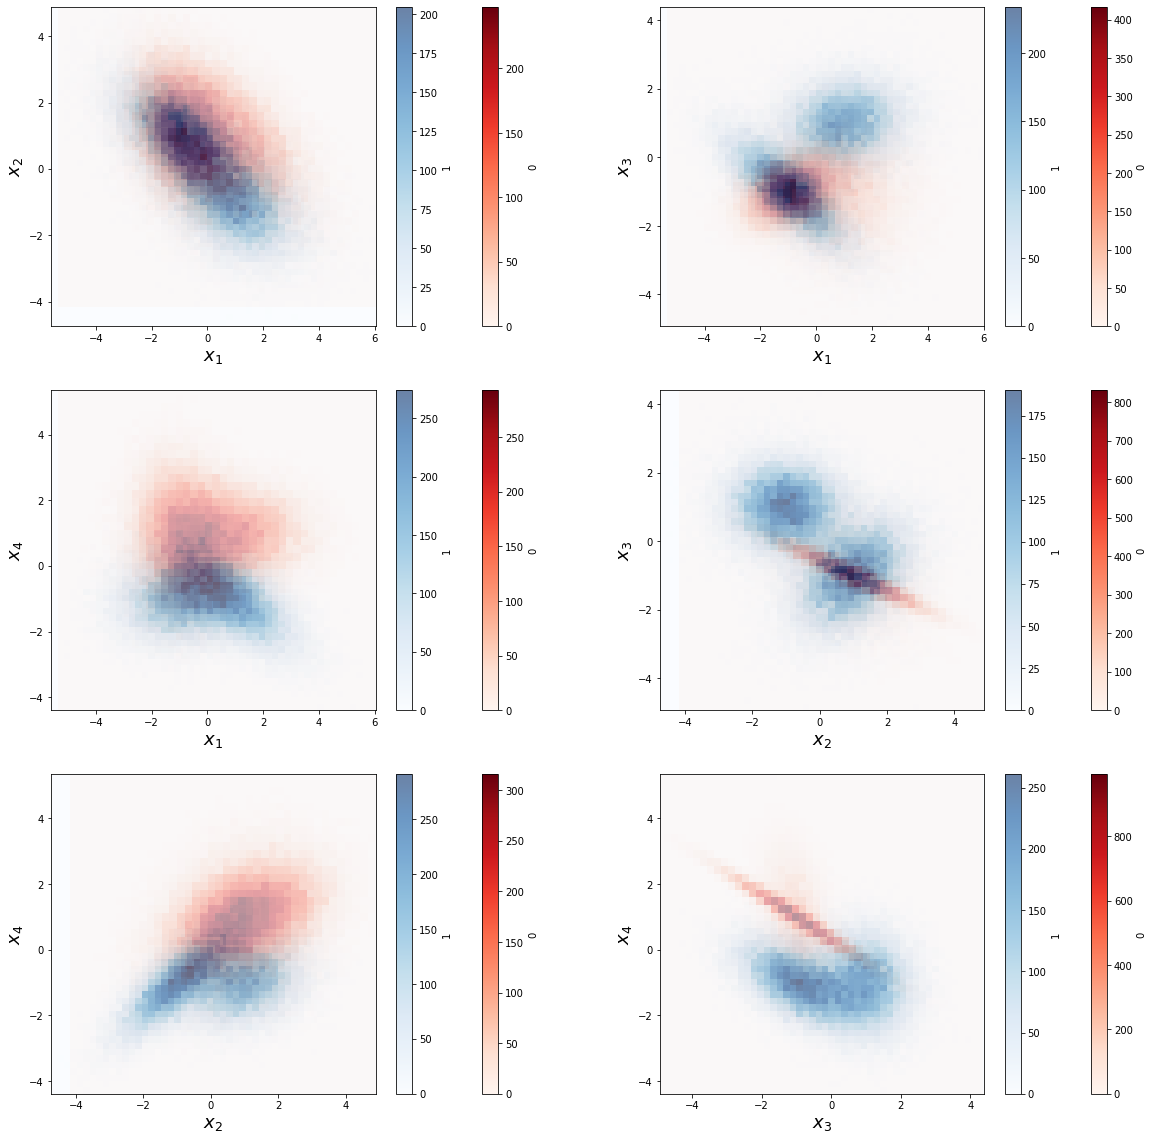

In [3]:
plt.rcParams['figure.figsize'] = [20, 20]

plt.subplot(3,2,1)
plt.hist2d(df.loc[df['y'] == 0]['x1'], df.loc[df['y'] == 0]['x2'], bins=50, cmap='Reds', alpha=1)
plt.colorbar(label='0')
plt.hist2d(df.loc[df['y'] == 1]['x1'], df.loc[df['y'] == 1]['x2'], bins=50, cmap='Blues', alpha=0.6)
plt.colorbar(label='1')
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18)

plt.subplot(3,2,2)
plt.hist2d(df.loc[df['y'] == 0]['x1'], df.loc[df['y'] == 0]['x3'], bins=50, cmap='Reds', alpha=1)
plt.colorbar(label='0')
plt.hist2d(df.loc[df['y'] == 1]['x1'], df.loc[df['y'] == 1]['x3'], bins=50, cmap='Blues', alpha=0.6)
plt.colorbar(label='1')
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_3$', fontsize=18)

plt.subplot(3,2,3)
plt.hist2d(df.loc[df['y'] == 0]['x1'], df.loc[df['y'] == 0]['x4'], bins=50, cmap='Reds', alpha=1)
plt.colorbar(label='0')
plt.hist2d(df.loc[df['y'] == 1]['x1'], df.loc[df['y'] == 1]['x4'], bins=50, cmap='Blues', alpha=0.6)
plt.colorbar(label='1')
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_4$', fontsize=18)

plt.subplot(3,2,4)
plt.hist2d(df.loc[df['y'] == 0]['x2'], df.loc[df['y'] == 0]['x3'], bins=50, cmap='Reds', alpha=1)
plt.colorbar(label='0')
plt.hist2d(df.loc[df['y'] == 1]['x2'], df.loc[df['y'] == 1]['x3'], bins=50, cmap='Blues', alpha=0.6)
plt.colorbar(label='1')
plt.xlabel('$x_2$', fontsize=18)
plt.ylabel('$x_3$', fontsize=18)

plt.subplot(3,2,5)
plt.hist2d(df.loc[df['y'] == 0]['x2'], df.loc[df['y'] == 0]['x4'], bins=50, cmap='Reds', alpha=1)
plt.colorbar(label='0')
plt.hist2d(df.loc[df['y'] == 1]['x2'], df.loc[df['y'] == 1]['x4'], bins=50, cmap='Blues', alpha=0.6)
plt.colorbar(label='1')
plt.xlabel('$x_2$', fontsize=18)
plt.ylabel('$x_4$', fontsize=18)

plt.subplot(3,2,6)
plt.hist2d(df.loc[df['y'] == 0]['x3'], df.loc[df['y'] == 0]['x4'], bins=50, cmap='Reds', alpha=1)
plt.colorbar(label='0')
plt.hist2d(df.loc[df['y'] == 1]['x3'], df.loc[df['y'] == 1]['x4'], bins=50, cmap='Blues', alpha=0.6)
plt.colorbar(label='1')
plt.xlabel('$x_3$', fontsize=18)
plt.ylabel('$x_4$', fontsize=18)

plt.show()

## Machine Learning
We start with some adjustable parameters:
- `train` $\doteq$ The portion of data to use for training
- `n_epochs` $\doteq$ Number of times the network looks at the data and adjusts the network
- `chunk size` $\doteq$ Number of samples to train over at a time
- `lr` $\doteq$ The Learning rate which can be thought of as the 'step size' the network takes at the end of each epoch
- `n_nodes` $\doteq$ The is the number of coefficients used within this single-layer network

In [28]:
train = 0.95
n_epochs = 1000
chunk_size = 500
lr = 1e-5
n_nodes = 200

### Create our training/testing tensors and build our network
Note that all of these are sent to the GPU by ending each line with `.cuda()`

In [29]:
t_size = int(train*len(df))

inputs = torch.tensor(df.iloc[:t_size,:4].values, dtype = torch.float32).cuda()
target = torch.tensor(df.iloc[:t_size, 4].values, dtype = torch.float32).cuda()

test_inputs = torch.tensor(df.iloc[t_size:,:4].values, dtype = torch.float32).cuda()
test_target = torch.tensor(df.iloc[t_size:,4].values, dtype = torch.float32).cuda()

model = torch.nn.Sequential(
    torch.nn.Linear(inputs.shape[1],n_nodes),
    torch.nn.ReLU(),
    torch.nn.Linear(n_nodes,1),
    torch.nn.Sigmoid()
).cuda()

model.train()

Sequential(
  (0): Linear(in_features=4, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=1, bias=True)
  (3): Sigmoid()
)

### Define our loss function and optimizer
We will be using the [Binary Cross Entropy Loss Function](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) and the [ADAM Optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)

In [30]:
lossFunc = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### Split our inputs and targets into chuncks

In [31]:
num_mb = int(math.floor(inputs.shape[0]/chunk_size))
input_mb = inputs.chunk(num_mb)
output_mb = target.chunk(num_mb)

test_target_mb = test_target.chunk(num_mb)
test_inputs_mb = test_inputs.chunk(num_mb)

### Start tracking our loss before training (epoch 0)

In [32]:
lossOut = []
lossTest = []
lossIn = np.arange(0, n_epochs + 1, 1)

prediction = torch.squeeze(model(inputs))
testLoss = lossFunc(torch.squeeze(model(test_inputs)),test_target)
loss = lossFunc(prediction,target)
lossOut.append(loss.tolist())
lossTest.append(testLoss.tolist())

### Train the network

In [33]:
for epoch in tqdm(range(n_epochs)):
    for minibatch in range(num_mb):
        prediction = torch.squeeze(model(input_mb[minibatch]))
        testLoss = lossFunc(torch.squeeze(model(test_inputs_mb[math.floor(minibatch/2)])),
                            test_target_mb[math.floor(minibatch/2)])
        loss = lossFunc(prediction,output_mb[minibatch])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    lossOut.append(loss.tolist())
    lossTest.append(testLoss.tolist())

print('Training done!') 

100%|██████████| 1000/1000 [03:44<00:00,  4.45it/s]

Training done!


### Plot the loss as a function of epochs to measure network performance 

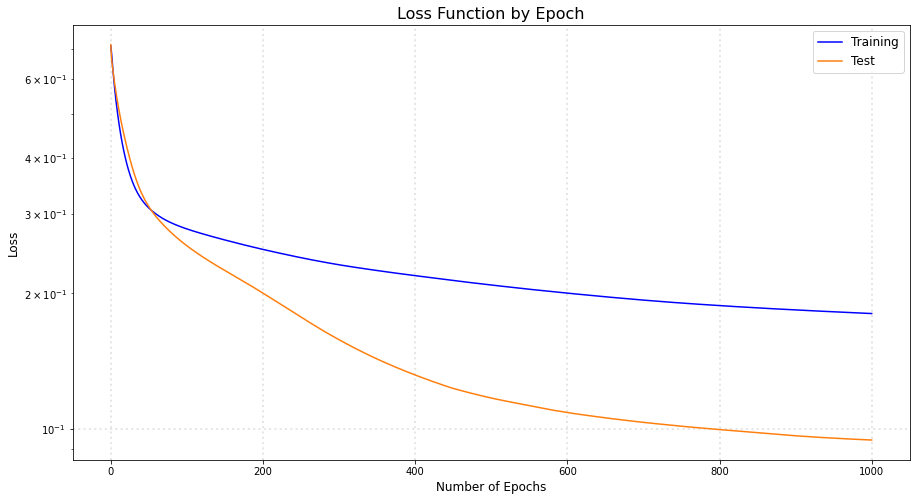

In [34]:
plt.rcParams['figure.figsize'] = [15, 8]
plt.plot(lossIn, lossOut, 'b', label='Training')
plt.plot(lossIn, lossTest, 'tab:orange', label='Test')
plt.grid(b=True, color='grey', alpha=0.2, linestyle=':', linewidth=2)
plt.xlabel('Number of Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.yscale('log')
plt.title('Loss Function by Epoch', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.show()

### Create ROC curves to measure performance
ROC stands for Receiver Operating Characteristic curve. This plots true postive rate as a function of false positive rate. A perfectly performing classifier will look like the upper left corner of a rectangle. 

/tmpscratch/cmcgrad2/.local/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


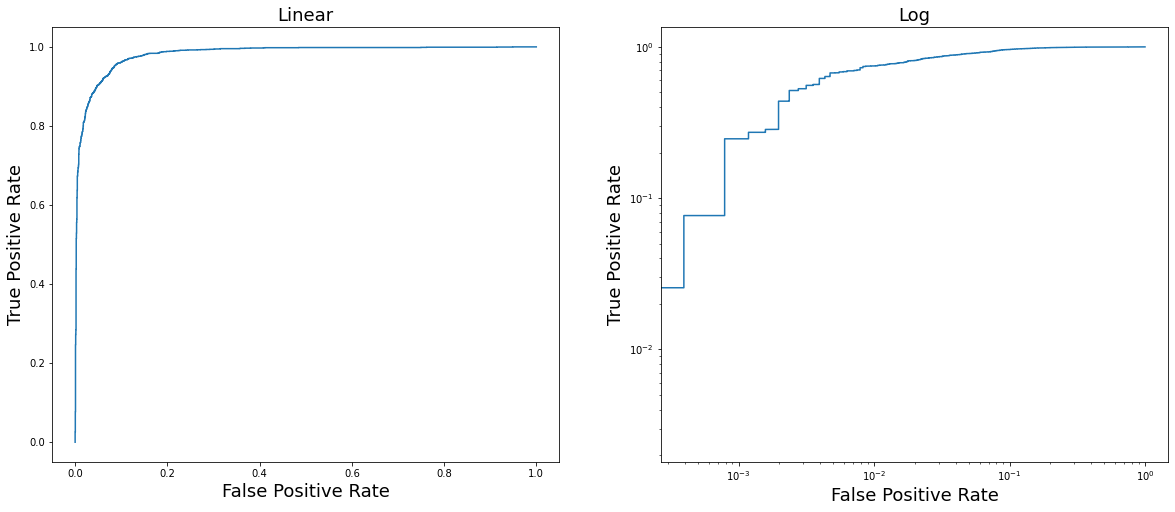

In [35]:
pred = torch.squeeze(model(test_inputs)).detach().cpu()
test_target = test_target.detach().cpu()

roc = ROC(pos_label=1)
fpr, tpr, thresholds = roc(pred, test_target)

plt.rcParams['figure.figsize'] = [20, 8]

plt.subplot(1,2,1)
plt.plot(fpr, tpr)
plt.title('Linear', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)

plt.subplot(1,2,2)
plt.plot(fpr, tpr)
plt.title('Log', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.xscale('log')
plt.yscale('log')